In [2]:
import numpy as np
import matplotlib.pyplot as plt

# We will pick 5 values above 0.5 and 5 values below.
# these will be centers of gaussian values of two classes of data.
N=10
x1,y1 = np.random.multivariate_normal(mean=[0,1], cov = [[0.1, 0], [0, 0.1]], size=N).T
x2,y2 = np.random.multivariate_normal(mean=[1,0], cov = [[0.1, 0], [0, 0.1]], size=N).T

#print(x1,y1)
#print(x2,y2)

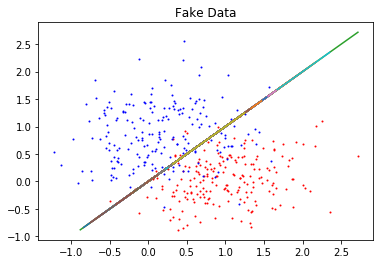

In [4]:
from itertools import chain

# Now generate 100 gaussian samples from each of these means.
N = 20
class_0 = [np.random.multivariate_normal(mean=[a,b], cov = [[0.2, 0], [0, 0.2]], size=N).T for (a,b) in zip(x2,y2)]
class_1 = [np.random.multivariate_normal(mean=[a,b], cov = [[0.2, 0], [0, 0.2]], size=N).T for (a,b) in zip(x1,y1)]

class_0 = [[s for subset in class_0 for s in subset[0]],[s for subset in class_0 for s in subset[1]]]
class_1 = [[s for subset in class_1 for s in subset[0]],[s for subset in class_1 for s in subset[1]]]

plt.title('Fake Data')
#plot the generated data
plt.scatter(class_0[0], class_0[1], color='r', s=1)
plt.scatter(class_1[0], class_1[1], color='b', s=1)
# plot the "ideal" decision boundary (corresponds to the generation method)
plt.plot(class_0, class_0)
plt.show()

In [6]:
# Logistic regression for the decision boundary
x_train = []
for i in range(len(class_0[0])):
    x_train.append((class_0[0][i], class_0[1][i]))
for i in range(len(class_1[0])):
    x_train.append((class_1[0][i], class_1[1][i]))
#print(x_train)
y_train = [1]*len(class_0[0]) + [0]*len(class_1[0])
#print(y_train)


In [7]:
# Logistic regression for the decision boundary
from sklearn.linear_model import LogisticRegression

model1 = LogisticRegression(solver="lbfgs").fit(x_train, y_train)
print(model1.coef_)
print(model1.intercept_)

[[ 2.76079749 -3.70136397]]
[-0.10980106]


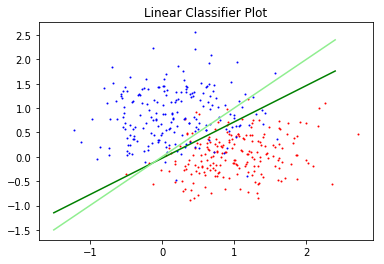

In [14]:
# plot the decision boundary
#  th[0]*x[0] + th[1]*x[1] + b = 0
#  -(th[0]*x[0] + b)/th[1] = x[1]
th0, th1 = model1.coef_[0]
b = model1.intercept_[0]

plt.title('Linear Classifier Plot')
plt.scatter(class_0[0], class_0[1], color='r', s=1)
plt.scatter(class_1[0], class_1[1], color='b', s=1)

# plot the calculated decision boundary.
func = lambda x: -(th0*x + model1.intercept_[0])/th1
x_values = np.array([x for x in np.arange(-1.5, 2.5, 0.1)])
plt.plot(x_values, func(x_values), c="g")

# plot the "ideal" decision boundary (corresponds to the generation method)
plt.plot(x_values, x_values, c="lightgreen")

plt.show()

In [15]:
# Same data, knn classifier
from sklearn.neighbors import KNeighborsClassifier
from matplotlib.colors import ListedColormap
k = 3
model2 = KNeighborsClassifier(k, 'uniform').fit(x_train, y_train)

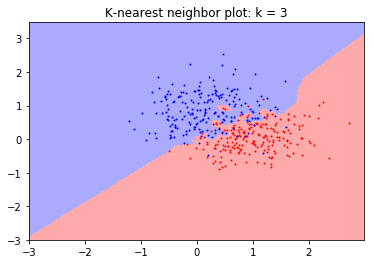

In [16]:
X = np.matrix(list(zip(*x_train)))
x_min, x_max = -3, 3
y_min, y_max = -3, 3.5
h = .02  # step size in the mesh

xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
Z = model2.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
cmap_light = ListedColormap(['#AAAAFF', '#FFAAAA'])
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)
plt.scatter(class_0[0], class_0[1], color='r', s=1)
plt.scatter(class_1[0], class_1[1], color='b', s=1)
plt.title("K-nearest neighbor plot: k = {}".format(k))
plt.show()

In [17]:
# what is the mean squared error of each of these two classifiers?
SE = lambda x,y: (x-y)**2
SSE1 = sum([SE(x,y) for (x,y) in zip(model1.predict(x_train), y_train)])/float(len(y_train))
print(SSE1)
SSE2 = sum([SE(x,y) for (x,y) in zip(model2.predict(x_train), y_train)])/float(len(y_train))
print(SSE2)

0.1075
0.06


In [18]:
# We have trained two classifiers.  Is one better than the other?  Better in what sense?  The 
# shape of the decision boundaries seems to tell us that one classifier is taking into account 
# the global structure of the training set and the other is more focused on local structure of
# the training data.  
#
# How well do these models predict classes for data from this set that are not in the training data?  
# Since we know the distribution, we can generate this data directly.  We will use 100 sets of 100 new points 
# to investigate prediction.
N = 20
def generate_data(N):
  x_test_0 = np.array([np.random.multivariate_normal(mean=[a,b], cov = [[0.2, 0], [0, 0.2]], size=N) for (a,b) in zip(x2,y2)]).reshape(-1, 2)
  x_test_1 = np.array([np.random.multivariate_normal(mean=[a,b], cov = [[0.2, 0], [0, 0.2]], size=N) for (a,b) in zip(x1,y1)]).reshape(-1, 2)
  return x_test_0, x_test_1, [0]*x_test_0.shape[0], [1]*x_test_1.shape[0]

a0,a1,b0,b1 = generate_data(N)
print(a0.shape)
print(a1.shape)

(200, 2)
(200, 2)


Since we know the actual separation of the two classes (the decision boundary), we can examine the actual error of our classifiers as well as a guess of the error.  Let's call the actual separation $f(x)=x + \epsilon$ where $\epsilon$ represents the intrinsic error in the data.  

How close are our models to f?  Because our data has noise in it, we can't match f exactly, so we need a way to measure our best match to the function while taking into account error that is unpredictable.  We will want to measure the difference between our prediction and the actual function.  In a real problem we dont know f, but only some of the data associated with f.  Since in our example we are generating the data, we have data both to train our models and as much data as we want to test the models.  So how do we do that?

What we need is:

1. Test data
2. A way to measure error

Test data is easy with the procedure `generate_data`.  We can generate lots of data sets.

There are many ways to measure error.  The easiest way to think about error is to think of it as measuring a distance between the actual generating function f values and the model predictions.  If the distance is smaller, then our model matches the data better.  If the distance is larger, then the model does not match the data as well.  We will use the squared distance from model prediction to the data to estimate the error of the model for a set of data values.

So let $x_0$. Then we can calculate $(f(x_1) - \hat{f}(x_1))^2$, where $\hat{f}$ is a model, as the squared distance from the model to the actual function.  We can sum a series of these squares and then divide by the number of points to get the mean squared error (MSE) for a set of data:

$$\sum_{n=1}^{N}(f(x_n) - \hat{f}(x_n))^2$$
